#  Amazon Review Sentimental Analysis Feature Extraction

In [2]:
import json
import numpy as np
import pandas as pd
import string 
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
musical = pd.read_json("Musical_Instruments_5.json",lines=True)
musical.to_csv('musical_instruments.csv','w')
musical.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [4]:
len(musical)

10261

In [5]:
musical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10261 non-null  object
 1   asin            10261 non-null  object
 2   reviewerName    10234 non-null  object
 3   helpful         10261 non-null  object
 4   reviewText      10261 non-null  object
 5   overall         10261 non-null  int64 
 6   summary         10261 non-null  object
 7   unixReviewTime  10261 non-null  int64 
 8   reviewTime      10261 non-null  object
dtypes: int64(2), object(7)
memory usage: 721.6+ KB


In [6]:
musical.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

####  Reviewname has null values but we are ignoring reviwername since we have reviwerID

In [7]:
len(musical.asin.unique()),len(musical.reviewerName.unique()),len(musical.reviewerID.unique())

(900, 1398, 1429)

###  Combining both reviewText and summary as reviewtext

In [8]:
musical["reviewtext"] = musical["reviewText"] + " " + musical["summary"]
musical = musical.drop(["reviewText","summary","reviewerName","helpful","unixReviewTime","reviewTime"],axis=1)
musical

,reviewerID,asin,overall,reviewtext
0,A2IBPI20UZIR0U,1384719342,5,"Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,1384719342,5,The product does exactly as it should and is q...
2,A195EZSQDW3E21,1384719342,5,The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,1384719342,5,Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,1384719342,5,This pop filter is great. It looks and perform...
...,...,...,...,...
10256,A14B2YH83ZXMPP,B00JBIVXGC,5,"Great, just as expected. Thank to all. Five S..."
10257,A1RPTVW5VEOSI,B00JBIVXGC,5,I've been thinking about trying the Nanoweb st...
10258,AWCJ12KBO5VII,B00JBIVXGC,4,I have tried coated strings in the past ( incl...
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,4,"Well, MADE by Elixir and DEVELOPED with Taylor..."


###    Preprocessing

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob

In [10]:
mus_ins = pd.DataFrame(musical["reviewtext"])
mus_ins

,reviewtext
0,"Not much to write about here, but it does exac..."
1,The product does exactly as it should and is q...
2,The primary job of this device is to block the...
3,Nice windscreen protects my MXL mic and preven...
4,This pop filter is great. It looks and perform...
...,...
10256,"Great, just as expected. Thank to all. Five S..."
10257,I've been thinking about trying the Nanoweb st...
10258,I have tried coated strings in the past ( incl...
10259,"Well, MADE by Elixir and DEVELOPED with Taylor..."


In [11]:
mus_ins.reviewtext[0]

"Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing, good"

In [12]:
def clean_text(text):
    text = text.lower()                                                       # lower case
    text = re.sub(r"\S*https?:\S*", "", text)                                 # removing links
    text = re.sub('\[.*?\]', '', text)                                        # removing text in square brackets
    text = re.sub(r"[’…]", "", text)                                          # removing special chracters
    text = re.sub("[0-9" "]+"," ",text)                                       # removing numbers
    text = text.translate(str.maketrans('', '', string.punctuation))          # remove punctuations 
    text_tokens = word_tokenize(text)                                         # Tokenization
    stop_words = stopwords.words('english')
    stop_tokens = [word for word in text_tokens if not word in stop_words]    # Remove stop words
    stop_text = ' '.join(stop_tokens)
    lemmas = TextBlob(stop_text)         
    lemmas_token = [w.lemmatize() for w in lemmas.words]                      # Lemmatization
    lemmas_text = ' '.join(lemmas_token)
    return lemmas_text
clean = lambda x: clean_text(x)

In [13]:
mus_ins["Text"] = mus_ins["reviewtext"].apply(clean)
mus_ins

,reviewtext,Text
0,"Not much to write about here, but it does exac...",much write exactly supposed filter pop sound r...
1,The product does exactly as it should and is q...,product exactly quite affordablei realized dou...
2,The primary job of this device is to block the...,primary job device block breath would otherwis...
3,Nice windscreen protects my MXL mic and preven...,nice windscreen protects mxl mic prevents pop ...
4,This pop filter is great. It looks and perform...,pop filter great look performs like studio fil...
...,...,...
10256,"Great, just as expected. Thank to all. Five S...",great expected thank five star
10257,I've been thinking about trying the Nanoweb st...,ive thinking trying nanoweb string bit put hig...
10258,I have tried coated strings in the past ( incl...,tried coated string past including elixir neve...
10259,"Well, MADE by Elixir and DEVELOPED with Taylor...",well made elixir developed taylor guitar strin...


In [14]:
text = ",".join(mus_ins["Text"])

###   Frequency Distribution

In [15]:
freq = pd.Series(' '.join(mus_ins['Text']).split()).value_counts()[:10]
freq

guitar    7285
great     5900
string    5082
one       4927
sound     4870
good      4860
like      4099
use       3899
pedal     3898
work      3666
dtype: int64

###   Bag of words 

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
cv = CountVectorizer()
x = cv.fit_transform(mus_ins["Text"])
freq_words = pd.DataFrame({'term': cv.get_feature_names(), 'occurrences':np.asarray(x.sum(axis=0)).ravel().tolist()})
freq_words['frequency'] = freq_words['occurrences']/np.sum(freq_words['occurrences'])

In [18]:
freq_words.head(25)

,term,occurrences,frequency
0,aa,13,0.000026
1,aaa,15,0.000030
2,ab,31,0.000063
3,aback,1,0.000002
4,abalone,10,0.000020
5,abalonefender,1,0.000002
6,abandon,1,0.000002
7,abbe,1,0.000002
8,abcd,4,0.000008
9,abehringer,2,0.000004


###   TFID 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
tfid_vec = TfidfVectorizer(stop_words='english', max_features= 2000, smooth_idf=True)
doc_vec = tfid_vec.fit_transform(mus_ins["Text"])
names_features = tfid_vec.get_feature_names()
dense = doc_vec.todense()
denselist = dense.tolist()
data = pd.DataFrame(denselist, columns = names_features)

In [21]:
data

,ab,ability,able,absolutely,abuse,ac,acceptable,access,accessory,accuracy,...,yeti,youd,youll,young,youre,youtube,youve,zero,zipper,zoom
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.176718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.146929,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10256,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
10257,0.0,0.0,0.045352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.060383,0.0,0.0,0.160159,0.0,0.0,0.0,0.0,0.0
10258,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
10259,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


###  N-gram

###   MonoGrams

In [24]:
def get_monograms(corpus, n=None):
    cv_1 = CountVectorizer(ngram_range=(1,1), max_features=2000).fit(corpus)
    bag_words = cv_1.transform(corpus)
    sum_words = bag_words.sum(axis=0) 
    freq_words = [(word, sum_words[0, idx]) for word, idx in cv_1.vocabulary_.items()]
    freq_words =sorted(freq_words, key = lambda x: x[1], reverse=True)
    return freq_words[:n]

In [25]:
top_words = get_monograms(mus_ins["Text"], n=150) 
top_150 = pd.DataFrame(top_words)
top_150.columns=["Monogram", "Freq"]
top_150.head()

,Monogram,Freq
0,guitar,7285
1,great,5900
2,string,5082
3,one,4927
4,sound,4870


[Text(0, 0, 'guitar'),
 Text(1, 0, 'great'),
 Text(2, 0, 'string'),
 Text(3, 0, 'one'),
 Text(4, 0, 'sound'),
 Text(5, 0, 'good'),
 Text(6, 0, 'like'),
 Text(7, 0, 'use'),
 Text(8, 0, 'pedal'),
 Text(9, 0, 'work'),
 Text(10, 0, 'well'),
 Text(11, 0, 'get'),
 Text(12, 0, 'price'),
 Text(13, 0, 'pick'),
 Text(14, 0, 'amp'),
 Text(15, 0, 'would'),
 Text(16, 0, 'really'),
 Text(17, 0, 'little'),
 Text(18, 0, 'nice'),
 Text(19, 0, 'dont')]

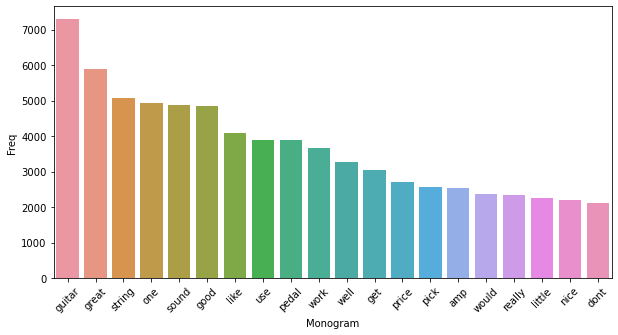

In [26]:
top_mono = top_150.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot=sns.barplot(x=top_mono["Monogram"],y=top_mono["Freq"])
plot.set_xticklabels(rotation=45,labels = top_mono["Monogram"])

###   Bigrams

In [27]:
def get_Bigrams(corpus, n=None):
    cv_2= CountVectorizer(ngram_range=(2,2), max_features=2000).fit(corpus)
    bag_words = cv_2.transform(corpus)
    sum_words = bag_words.sum(axis=0) 
    freq_words = [(word, sum_words[0, idx]) for word, idx in cv_2.vocabulary_.items()]
    freq_words =sorted(freq_words, key = lambda x: x[1], reverse=True)
    return freq_words[:n]

In [28]:
top_words = get_Bigrams(mus_ins["Text"], n=200) 
top_200 = pd.DataFrame(top_words)
top_200.columns=["Bi-gram", "Freq"]
top_200.head()

,Bi-gram,Freq
0,work well,671
1,work great,633
2,acoustic guitar,416
3,sound great,404
4,easy use,325


[Text(0, 0, 'work well'),
 Text(1, 0, 'work great'),
 Text(2, 0, 'acoustic guitar'),
 Text(3, 0, 'sound great'),
 Text(4, 0, 'easy use'),
 Text(5, 0, 'electric guitar'),
 Text(6, 0, 'planet wave'),
 Text(7, 0, 'well made'),
 Text(8, 0, 'great price'),
 Text(9, 0, 'sound good'),
 Text(10, 0, 'pedal board'),
 Text(11, 0, 'good quality'),
 Text(12, 0, 'sound like'),
 Text(13, 0, 'would recommend'),
 Text(14, 0, 'much better'),
 Text(15, 0, 'guitar string'),
 Text(16, 0, 'le paul'),
 Text(17, 0, 'work fine'),
 Text(18, 0, 'great product'),
 Text(19, 0, 'long time')]

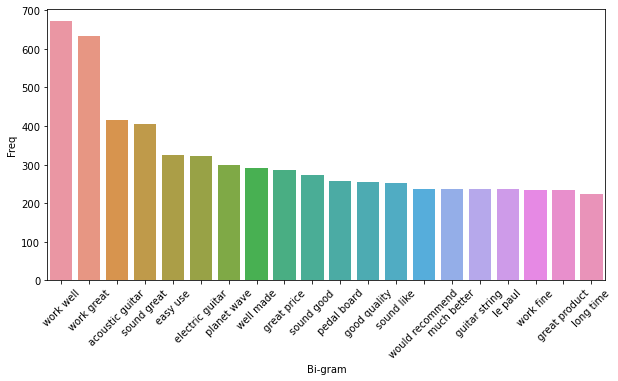

In [29]:
top_bi = top_200.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot=sns.barplot(x=top_bi["Bi-gram"],y=top_bi["Freq"])
plot.set_xticklabels(rotation=45,labels = top_bi["Bi-gram"])

###   TriGram

In [30]:
def get_Trigrams(corpus, n=None):
    cv_3 = CountVectorizer(ngram_range=(3,3), max_features=2000).fit(corpus)
    bag_words = cv_3.transform(corpus)
    sum_words = bag_words.sum(axis=0) 
    freq_words = [(word, sum_words[0, idx]) for word, idx in cv_3.vocabulary_.items()]
    freq_words =sorted(freq_words, key = lambda x: x[1], reverse=True)
    return freq_words[:n]

In [31]:
top_words = get_Trigrams(mus_ins["Text"], n=250) 
top_250 = pd.DataFrame(top_words)
top_250.columns=["Tri-gram", "Freq"]
top_250.head()

,Tri-gram,Freq
0,cant go wrong,121
1,get job done,88
2,last long time,87
3,would recommend anyone,53
4,acoustic electric guitar,49


[Text(0, 0, 'cant go wrong'),
 Text(1, 0, 'get job done'),
 Text(2, 0, 'last long time'),
 Text(3, 0, 'would recommend anyone'),
 Text(4, 0, 'acoustic electric guitar'),
 Text(5, 0, 'built like tank'),
 Text(6, 0, 'ernie ball string'),
 Text(7, 0, 'ive ever used'),
 Text(8, 0, 'would highly recommend'),
 Text(9, 0, 'sound much better'),
 Text(10, 0, 'cant beat price'),
 Text(11, 0, 'great little tuner'),
 Text(12, 0, 'solid state amp'),
 Text(13, 0, 'worth every penny'),
 Text(14, 0, 'local music store'),
 Text(15, 0, 'gibson le paul'),
 Text(16, 0, 'buy another one'),
 Text(17, 0, 'acoustic guitar string'),
 Text(18, 0, 'work really well'),
 Text(19, 0, 'price cant beat')]

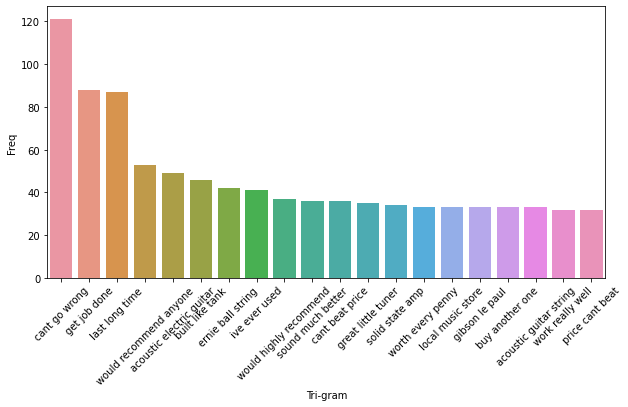

In [32]:
top_tri = top_250.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot=sns.barplot(x=top_tri["Tri-gram"],y=top_tri["Freq"])
plot.set_xticklabels(rotation=45,labels = top_tri["Tri-gram"])